# Loading Packages & Initialization

reference : https://gist.github.com/mertedali/ab7078b9c29dea18c72525239d636b96

In [2]:
library(data.table)
library(tidyverse)
library(rJava)
library(RNetLogo)

library(lhs) # For maximin Latin hypercube sampling
library(ggplot2)
library(caret)
library(randomForest)
library(factoextra)
library(e1071)
library(TSrepr) # for evaluating predictive power

options(warn = -1)

In [3]:
Is_Headless <- 0

nl.path <- "C:/Program Files/NetLogo 6.0.4/app"
model.path <- "C:/Users/paslanpatir/Desktop/TEZ_v2/Segregation.nlogo"

if (Is_Headless == 0){
    NLStart(nl.path, gui = TRUE,nl.jarname='netlogo-6.0.4.jar')
    NLLoadModel (model.path)
    } else {
    NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar', nl.obj = netlogo_model_1)
    NLLoadModel (model.path, nl.obj = netlogo_model_1 )
    }

# Model Functions

In [4]:
set.seed(385)

#Set model parameters
nofrep = 10         # Number of replications for each instance
nofparams = 2       # Number of input parameters of the agent-based model

In [5]:
run_model <- function(d,s) { #d: density, s: similar_wanted
    #list the parameters
    NLCommand( paste("set density", d))
    NLCommand( paste("set %-similar-wanted", s))
    NLCommand("setup")
    NLDoCommand(100, "go") 
 #   NLDoCommandWhile("any? turtles [not happy?]", "go")
    result <- NLReport("percent-similar")
    return(result)
}

In [6]:
run_replicas <- function(nofrep,d,s) {
    replicas = matrix(NA, ncol = nofrep, nrow = 1) # Save the result of each replication
    for(i in 1:nofrep){
        replicas[i]= run_model(d,s)
    }
    aggregated_result = mean(replicas)
    return(aggregated_result)
}


In [7]:
#error functions
rmse_func <- function(actual, predicted){
    error = predicted - actual
    return(sqrt(mean(error^2)))
}

mape_func <- function(actual,predicted){
    return( (abs(actual - predicted)/ actual)*100 )
}

bias_func <- function(actual,predicted){
    return( (actual - predicted)/ actual )
}

In [ ]:
#eliminate_variable <- function(){}

# Generate Training Set

## Training set with stepped inputs

In [ ]:
#d <- seq(10,100,20) #density values btn  1 and 100, stepsize: 20
#s <- seq(10,100,20) #density values btn  1 and 100, stepsize: 20
#
#sample = tidyr::crossing(s, d) %>% as.data.table()

In [ ]:
#input_result = c()  
##m = c()
#for (j in 1:length(s)) {
#        input_vector <- as.vector(sapply(d, function(d) run_replicas(nofrep,d,s[j])) ) ## as.vector(sapply(d, function(d) run_model(d,s[j])) ) ## run_replicas
#        input_result <- rbind(input_result,t(t(input_vector)))
#    #     m = rbind(m,input_vector)
#    #    as.data.table(as.vector(t(m)))
#    }
#sample <- cbind(sample,input_result)
#setnames(sample,"V1","perc_similar")
#setcolorder(sample, c("d", "s", "perc_similar"))

In [ ]:
#fwrite(sample, "C:/Users/paslanpatir/Desktop/TEZ_v2/sample_Data_21112019.csv")

In [ ]:
#head(sample)

### Visualization

In [ ]:
#pca_sample <- princomp(sample[,.SD, .SDcols = !c("perc_similar")], cor = TRUE, scores = TRUE)
#cor = TRUE takes care of scaling

In [ ]:
#fviz_pca_ind(pca_sample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

In [ ]:
#pca_sample_components <- get_pca_ind(pca_sample)
#pca_sample_components <-cbind(pca_sample_components$coord[,1:2],sample[,.(perc_similar)])
#p_sample <- ggplot(data = pca_sample_components, aes(x = Dim.1, y = Dim.2)) +
#             geom_point(aes(colour = perc_similar)) +
#             labs( title = "", legend = "perc_similar") 
#p_sample

## Training set with maximinLHS

In [ ]:
nofinstances = 25 #length(d)* length(s)
LHSample = as.data.table(maximinLHS(n = nofinstances, k = nofparams, dup = 5))

LHSample$V1 = qunif(LHSample$V1, 10, 100) 
LHSample$V2 = qunif(LHSample$V2, 10, 100) 
setnames(LHSample, c("V1","V2"), c("d","s"))
LHSample$perc_similar <- 0.00

In [ ]:
for(i in 1:nofinstances){
        LHSample[i, perc_similar :=  run_replicas(nofrep,LHSample[i,1],LHSample[i,2])]         
}

In [ ]:
#fwrite(LHSample, "C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Data_20112019.csv")

In [8]:
LHSample <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Data_20112019.csv")
head(LHSample)

d,s,perc_similar
<dbl>,<dbl>,<dbl>
80.58390,34.47527,77.15161
49.25209,69.05979,99.69152
68.20054,49.77449,88.07650
88.91601,79.76180,51.45689
28.51136,27.25650,80.41930
26.82334,58.22569,98.65376


### Visualization

In [9]:
pca_LHSample <- princomp(LHSample[,.SD, .SDcols = !c("perc_similar")], cor = TRUE, scores = TRUE)

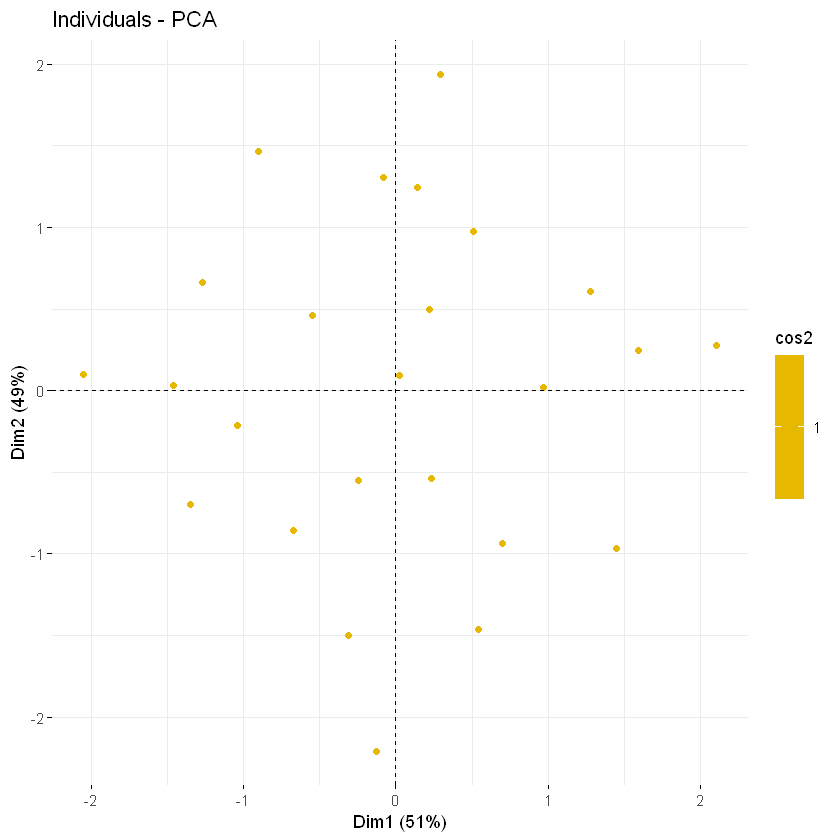

In [10]:
fviz_pca_ind(pca_LHSample,
             col.ind = "cos2", # Color by the quality of representation
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
              geom="point"
             )

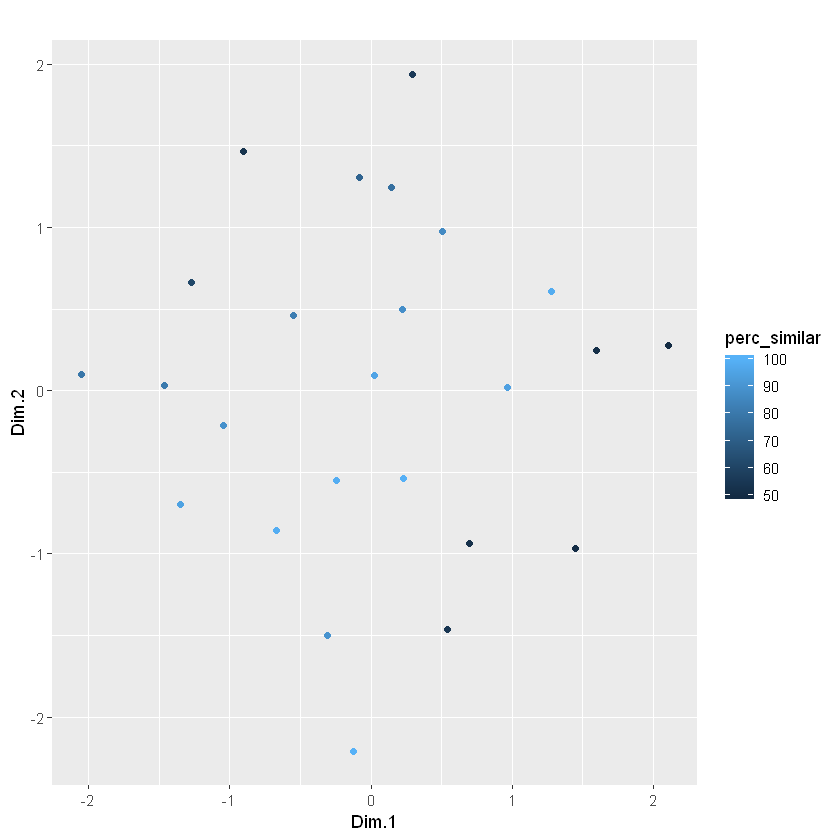

In [11]:
pca_LHSample_components <- get_pca_ind(pca_LHSample)
pca_LHSample_components <-cbind(pca_LHSample_components$coord[,1:2],LHSample[,.(perc_similar)])
p_LHSample <- ggplot(data = pca_LHSample_components, aes(x = Dim.1, y = Dim.2)) +
             geom_point(aes(colour = perc_similar)) +
             labs( title = "", legend = "perc_similar") 
p_LHSample

# Metamodel

Cross validation düşün?
Test et yarat

## Metamodel : RandomForest

Tuning!

In [28]:
model_rf <- randomForest(perc_similar ~ ., data = LHSample, importance = TRUE)
model_rf


Call:
 randomForest(formula = perc_similar ~ ., data = LHSample, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 227.4964
                    % Var explained: 31.92

[1] 24

[1] 13.04537

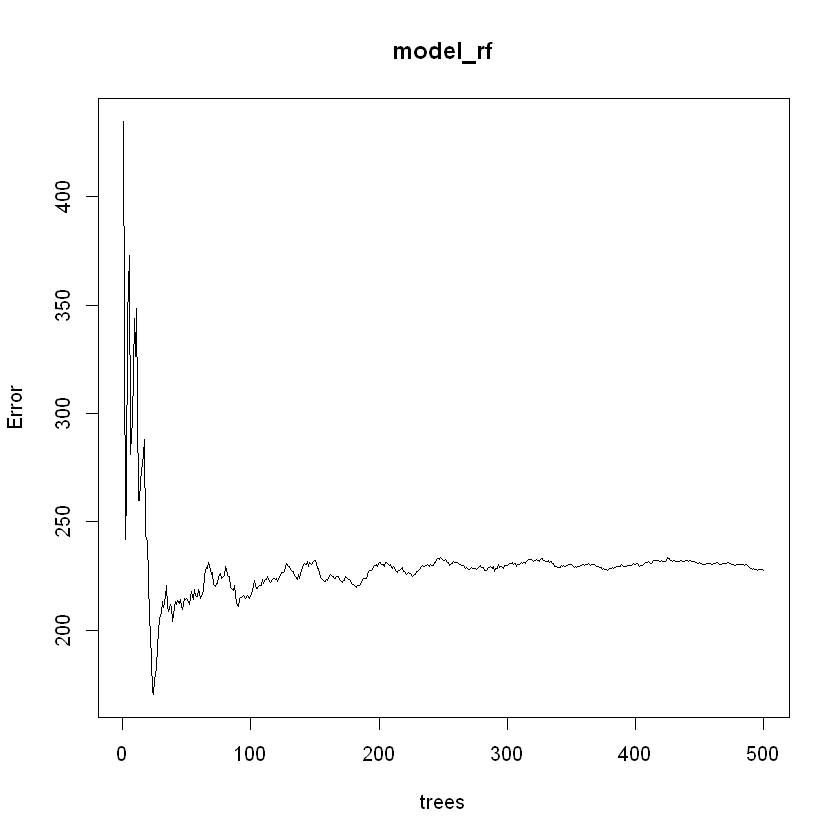

In [32]:
plot(model_rf)
# number of trees with lowest MSE
which.min(model_rf$mse)
## 

# RMSE of this optimal random forest
sqrt(model_rf$mse[which.min(model_rf$mse)])
## 

In [14]:
eliminate_variable <- function(){}

[1] 390

[1] 14.37425

In [ ]:
dat = copy(LHSample)


In [ ]:
model_rf <- randomForest(perc_similar ~ ., data = LHSample, importance = TRUE)
   
    importances <- importance(model_rf, type = 1, scale = FALSE)
    selected.vars <- order(importances, decreasing = TRUE)
    ordered.importances <- importances[selected.vars]
    
    initialImportances <- importances
    initialOrderedImportances <- ordered.importances

### Variable Importance

In [23]:
    importances <- importance(model_rf, type = 1, scale = FALSE)
    selected.vars <- order(importances, decreasing = TRUE)
    ordered.importances <- importances[selected.vars]
    
    initialImportances <- importances
    initialOrderedImportances <- ordered.importances

[1] 2 1

In [ ]:
importance(model_rf)
varImpPlot(model_rf)

In [21]:
importance(model_rf, type=1)

,%IncMSE
d,1.050175
s,18.341132


In [15]:
#model_rf$variable.importance %>% 
#  tidy() %>%
#  dplyr::arrange(desc(x)) %>%
#  dplyr::top_n(25) %>%
#  ggplot(aes(reorder(names, x), x)) +
#  geom_col() +
#  coord_flip() +
#  ggtitle("Top 25 important variables")

ERROR: Error in tidy(.): could not find function "tidy"


### Predictions

#### Predictions on Train Set

In [ ]:
predTrain <- predict(model_rf, LHSample[,.SD, .SDcols = !c("perc_similar")])

In [ ]:
predTrain

In [ ]:
predTrain <- cbind(LHSample,predTrain)
setnames(predTrain, "predTrain","pred_perc_similar")

In [ ]:
p1_test <- ggplot(predTrain,aes(x = perc_similar, y = pred_perc_similar, color = (pred_perc_similar - perc_similar))) +
            geom_point() +
            geom_abline() +
            xlab("actual values") +
            ylab("fitted values")

p1_test

In [ ]:
TSrepr::mae(predTrain$perc_similar, predTrain$pred_perc_similar)
TSrepr::rmse(predTrain$perc_similar, predTrain$pred_perc_similar)
TSrepr::mape(predTrain$perc_similar, predTrain$pred_perc_similar)

## Unlabeled Set

In [ ]:
nofunlabel_ins = 20
unlabeled_set <- head(sample,nofunlabel_ins)

In [ ]:
unlabeled_set$d = runif(nofunlabel_ins, 10, 100) 
unlabeled_set$s = runif(nofunlabel_ins, 10, 100) 
unlabeled_set[,c("perc_similar"):= NULL]

### Run ABM on Test Set

In [ ]:
for(i in 1:nofunlabel_ins){
        unlabeled_set[i, perc_similar :=  run_replicas(nofrep,unlabeled_set[i,1],unlabeled_set[i,2])]         
}

In [ ]:
#fwrite(unlabeled_set, "C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_set_20112019.csv")

In [ ]:
unlabeled_set

### Predictions on Unlabeled Set

In [ ]:
predUnlabeled <- predict(model_rf, unlabeled_set)

In [ ]:
predUnlabeled <- cbind(unlabeled_set,predUnlabeled)
setnames(predUnlabeled, "predUnlabeled","pred_perc_similar")

In [ ]:
predUnlabeled

In [ ]:
p_unlabeled <- ggplot(predUnlabeled,aes(x = perc_similar, y = pred_perc_similar, color = (pred_perc_similar - perc_similar))) +
            geom_point() +
            geom_abline() +
            xlab("actual values") +
            ylab("fitted values")

p_unlabeled

In [ ]:
TSrepr::mae(predUnlabeled$perc_similar, predUnlabeled$pred_perc_similar)
TSrepr::rmse(predUnlabeled$perc_similar, predUnlabeled$pred_perc_similar)
TSrepr::mape(predUnlabeled$perc_similar, predUnlabeled$pred_perc_similar)

# Same Parameter Set With Sequential Sampling

In [ ]:
sample_size <- 5
seq_LHSample <- copy(LHSample)
seq_LHSample$Seq_Group = 0
nofsequence = (nrow(seq_LHSample) / sample_size)

In [ ]:
# Assign sequence
for (s in 1:nofsequence){
    train = sample(nrow(seq_LHSample[Seq_Group == 0]), 5, replace = FALSE)
    seq_LHSample[Seq_Group == 0][train,]$Seq_Group <- s
}

## Train Metamodel

In [ ]:
performance_table = data.table(Seq_Group = numeric(), mae= numeric(),rmse= numeric(), mape = numeric()  )
t= 1

error_type ="mape"


preunlabeled_set <- copy(unlabeled_set)
formula = reformulate( colnames(seq_LHSample[,.SD,.SDcols = -c("Seq_Group","perc_similar")]),"perc_similar")
while( t <= sample_size){
    
    model_rf_seq <- randomForest(formula, data = seq_LHSample[Seq_Group <= t], importance = TRUE)
    predUnlabeled_seq <- predict(model_rf_seq, unlabeled_set)
    preunlabeled_set <- cbind(preunlabeled_set,predUnlabeled_seq)
    
    if(error_type == "mape"){
        preunlabeled_set[,MAPE := mapply(function(x,y) mape_func(x,y),perc_similar,predUnlabeled_seq )]
        setnames(preunlabeled_set, c("predUnlabeled_seq","MAPE") ,c(paste0("pred_perc_similar_",t),paste0("MAPE",t)))
        }

    #  setnames(preunlabeled_set, "predUnlabeled_seq",paste0("pred_perc_similar_",t))
    
        c = ((2 * t) - 1)
        performance_temp = matrix(c(1:4), nrow = 1, ncol = 4)
        performance_temp[1] = t
        performance_temp[2] = mae(preunlabeled_set$perc_similar  , preunlabeled_set[[3 + c]])
        performance_temp[3] = rmse(preunlabeled_set$perc_similar , preunlabeled_set[[3 + c]])
        performance_temp[4] = mape(preunlabeled_set$perc_similar , preunlabeled_set[[3 + c]])


    performance_table <- rbind(performance_table, performance_temp,use.names = FALSE )
    rm(performance_temp)
   
#add importance
#importance(model_rf)

                                         
        t = t+1
}

#setnames(predUnlabeled, "predUnlabeled","pred_perc_similar")
#importance(model_rf)
#varImpPlot(model_rf)

In [ ]:
preunlabeled_set

In [ ]:
 ggplot(data = performance_table, aes(x = Seq_Group, y = rmse)) +
   geom_line(aes(colour = "red"))

In [ ]:
plot_data = copy(preunlabeled_set)
plot_data[,idx := 1:.N]
measure_vars = c(paste0("MAPE",c(1:sample_size))) ### bunu entegre et

plot_data = melt(data = plot_data, id.vars = "idx"
                   , measure.vars = c("MAPE1", "MAPE2","MAPE3","MAPE4","MAPE5"))
                 #measure_vars #
setnames(plot_data, c("variable","value"),c("ModelName","MAPE"))

                 
ggplot(plot_data, aes(x=ModelName, y=MAPE, colors = "blue", fill = ModelName)) + 
  geom_boxplot(outlier.colour="red", outlier.shape=8, outlier.size=4) +
  labs( title = "Overall MAPE", legend = "ModelName")
#
#p3 <- ggplot(data = plot_data, aes(x = idx, y = MAPE)) +
#        geom_line(aes(colour = "red")) +
#        facet_wrap(~ Year, nrow= 4) +
#        labs( title = "Electricity Consumption in 2016", legend = "Date") +
#        geom_smooth(method = "lm")
#p3

In [ ]:
 ggplot(data = plot_data, aes(x = idx, y = MAPE)) +
   geom_line(aes(colour = "red")) +
   facet_wrap(~ ModelName, nrow= sample_size) 
  # labs( title = "Electricity Consumption in 2016", legend = "Date") +



In [ ]:
performance_table;
TSrepr::mae(predUnlabeled$perc_similar, predUnlabeled$pred_perc_similar)
TSrepr::rmse(predUnlabeled$perc_similar, predUnlabeled$pred_perc_similar)
TSrepr::mape(predUnlabeled$perc_similar, predUnlabeled$pred_perc_similar)

In [ ]:
  fita <- randomForest(formula, data = seq_LHSample[Seq_Group <= 5], importance = TRUE)
    preda <- predict(fita, unlabeled_set)

  fitb <- randomForest(formula, data = seq_LHSample, importance = TRUE)
    predb <- predict(fitb, unlabeled_set)

In [ ]:
preda;predb

In [ ]:
preda;predb

In [ ]:

model_rf_seq <- randomForest(perc_similar ~ ., data = LHSample[], importance = TRUE)
model_rf
importance(model_rf)
varImpPlot(model_rf)

## ghf

In [ ]:
d <- seq(1,100,5) #density values btn  1 and 100, stepsize: 5
pb <- sapply(d, function(dens) run_model(dens,30))
plot(d, pb, xlab = "density")

hepsi iye aynı bak bakalım.

In [ ]:
run_model(100,30)

In [ ]:
h <- run_model(70,30)
#plot (0:1010, h)
h

# Finish the session

In [ ]:
NLQuit()